In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

import scipy.stats as stats

import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
dir_plots = './plots'

In [79]:
df = pd.read_csv('merged_data.csv')
df

,mergeid,female,age,bmi,ENMO_hour,GGIR_N_valid_hours,hour,measurementday,weekday,month,...,country,disease,d1,d2,d3,d4,d5,d6,d7,control
0,Bf-031257-01,0,67.000000,21.155294,6.697222,0.0,12am-1am,1,Tuesday,February,...,Belgium,control,0,0,0,0,0,0,0,1
1,Bf-031257-01,0,67.000000,21.155294,10.741667,0.0,1am-2am,1,Tuesday,February,...,Belgium,control,0,0,0,0,0,0,0,1
2,Bf-031257-01,0,67.000000,21.155294,7.848472,0.5,2am-3am,1,Tuesday,February,...,Belgium,control,0,0,0,0,0,0,0,1
3,Bf-031257-01,0,67.000000,21.155294,0.244306,1.0,3am-4am,1,Tuesday,February,...,Belgium,control,0,0,0,0,0,0,0,1
4,Bf-031257-01,0,67.000000,21.155294,4.214167,1.0,4am-5am,1,Tuesday,February,...,Belgium,control,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136027,SI-992596-02,0,73.199997,30.864197,14.941944,1.0,7pm-8pm,7,Thursday,January,...,Slovenia,d2,0,1,0,0,0,0,0,0
136028,SI-992596-02,0,73.199997,30.864197,4.990833,1.0,8pm-9pm,7,Thursday,January,...,Slovenia,d2,0,1,0,0,0,0,0,0
136029,SI-992596-02,0,73.199997,30.864197,10.771528,1.0,9pm-10pm,7,Thursday,January,...,Slovenia,d2,0,1,0,0,0,0,0,0
136030,SI-992596-02,0,73.199997,30.864197,12.281944,1.0,10pm-11pm,7,Thursday,January,...,Slovenia,d2,0,1,0,0,0,0,0,0


Characteristics of the participants

total number of respondents

In [4]:
total_participants = df[df.columns[0]].count()
total_participants

136032

Counting responents in each group

In [15]:
df['disease']  = df[['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'control',]].apply(lambda x: x.idxmax(), axis=1)
df['disease'].value_counts()

control    60624
d1         38544
d4         10848
d3          7752
d5          7128
d2          7128
d7          3144
d6           864
Name: disease, dtype: int64

<AxesSubplot:xlabel='disease'>

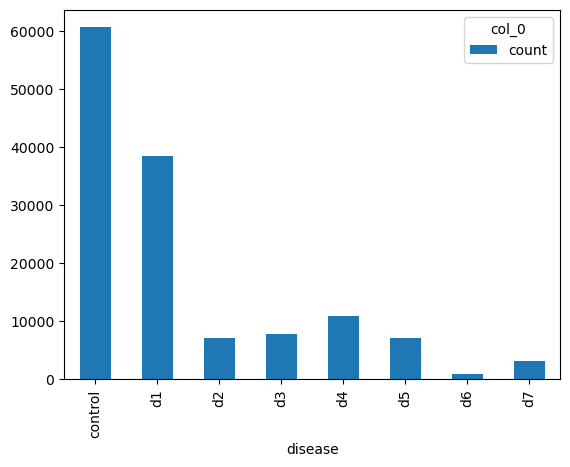

In [46]:
disease_table = pd.crosstab(index=df['disease'], columns='count')
disease_table.plot(kind='bar')

Age mean and standard devation

In [23]:
st_dev_age = df.groupby('disease')['age'].agg(['mean', 'std']) # for mean and std deviation
st_dev_age

,mean,std
disease,,
control,66.857680,8.507543
d1,70.960710,9.335759
d2,70.221886,8.712759
d3,70.260991,9.581593
d4,71.381195,6.985365
d5,70.351179,8.280292
d6,72.177778,6.387971
d7,71.755725,8.435515


BMI mean and standard devation

In [26]:
st_dev_BMI = df.groupby('disease')['bmi'].agg(['mean', 'std']) # for mean and std deviation
st_dev_BMI

,mean,std
disease,,
control,25.866338,4.745799
d1,28.158359,5.692944
d2,28.638853,4.373281
d3,26.194948,5.643387
d4,28.449585,7.853093
d5,29.449426,6.613942
d6,26.950420,3.417659
d7,28.043984,12.799799


Number of participants depending on gender

In [51]:
count_sex = df.groupby('disease')['female'].value_counts()
count_sex

disease  female
control  1         35040
         0         25584
d1       1         21600
         0         16944
d2       1          4008
         0          3120
d3       1          5784
         0          1968
d4       0          5808
         1          5040
d5       1          5712
         0          1416
d6       1           528
         0           336
d7       1          2112
         0          1032
Name: female, dtype: int64

in %:

In [55]:
for x in count_sex:
    print(x, '\t %.2f' % (x/total_participants*100))

35040 	 25.76
25584 	 18.81
21600 	 15.88
16944 	 12.46
4008 	 2.95
3120 	 2.29
5784 	 4.25
1968 	 1.45
5808 	 4.27
5040 	 3.71
5712 	 4.20
1416 	 1.04
528 	 0.39
336 	 0.25
2112 	 1.55
1032 	 0.76


In [5]:
def calc_ENMO_stats(df, enmo_col='ENMO_hour'):
    df = df.copy()
    mean = df.groupby('mergeid')[enmo_col].mean()
    median = df.groupby('mergeid')[enmo_col].median()
    var = df.groupby('mergeid')[enmo_col].var()
    mean.name = 'mean_ENMO'
    median.name = 'median_ENMO'
    var.name = 'var_ENMO'
    df = pd.merge(left=df, left_on='mergeid', right=mean, right_on='mergeid', how='left')
    df = pd.merge(left=df, left_on='mergeid', right=median, right_on='mergeid', how='left')
    df = pd.merge(left=df, left_on='mergeid', right=var, right_on='mergeid', how='left')
    return df

In [6]:
df_stat= calc_ENMO_stats(df)   
df_stat = df_stat.drop_duplicates(subset='mergeid', keep='first')
cols = ['ENMO_hour','GGIR_N_valid_hours','measurementday', 'hour', 'weekday']
df_stat.drop(cols, inplace=True, axis=1)
df_stat.head(5)

,mergeid,female,age,bmi,month,year,device_id,frequency,position,country,...,d2,d3,d4,d5,d6,d7,control,mean_ENMO,median_ENMO,var_ENMO
0,Bf-031257-01,0,67.000000,21.155294,February,2020,68652.0,50,Left,Belgium,...,0,0,0,0,0,0,1,12.164127,9.664236,119.962879
168,Bf-043946-02,1,57.299999,38.446751,February,2020,30920.0,50,Left,Belgium,...,0,0,0,0,0,0,0,13.780020,8.492361,209.996045
336,Bf-073169-01,0,72.500000,25.209202,March,2020,68652.0,50,Right,Belgium,...,0,0,0,0,0,0,0,16.090929,11.452292,537.459251
504,Bf-227520-04,0,56.099998,24.593210,March,2020,17212.0,50,Right,Belgium,...,0,0,0,0,0,0,0,11.543128,11.326111,74.794850
552,Bf-286437-02,1,68.099998,30.778702,February,2020,54007.0,50,Right,Belgium,...,0,0,0,0,0,0,0,38.811152,48.127569,367.199181


<AxesSubplot:title={'center':'median_ENMO'}, xlabel='disease'>

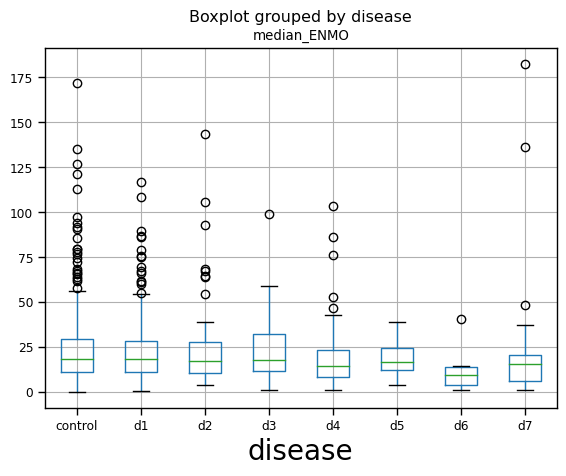

In [88]:
df_stat.boxplot(column='median_ENMO', by='disease')
#plt.savefig(os.path.join(dir_plots, "Boxplot_median.png"))

In [55]:
from matplotlib import cm
def qqplot(x, y,palette= cm.viridis, *args, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    sns.scatterplot(x=xr, y=yr, edgecolor="none", palette=palette, *args, **kwargs)

<Figure size 1000x1000 with 0 Axes>

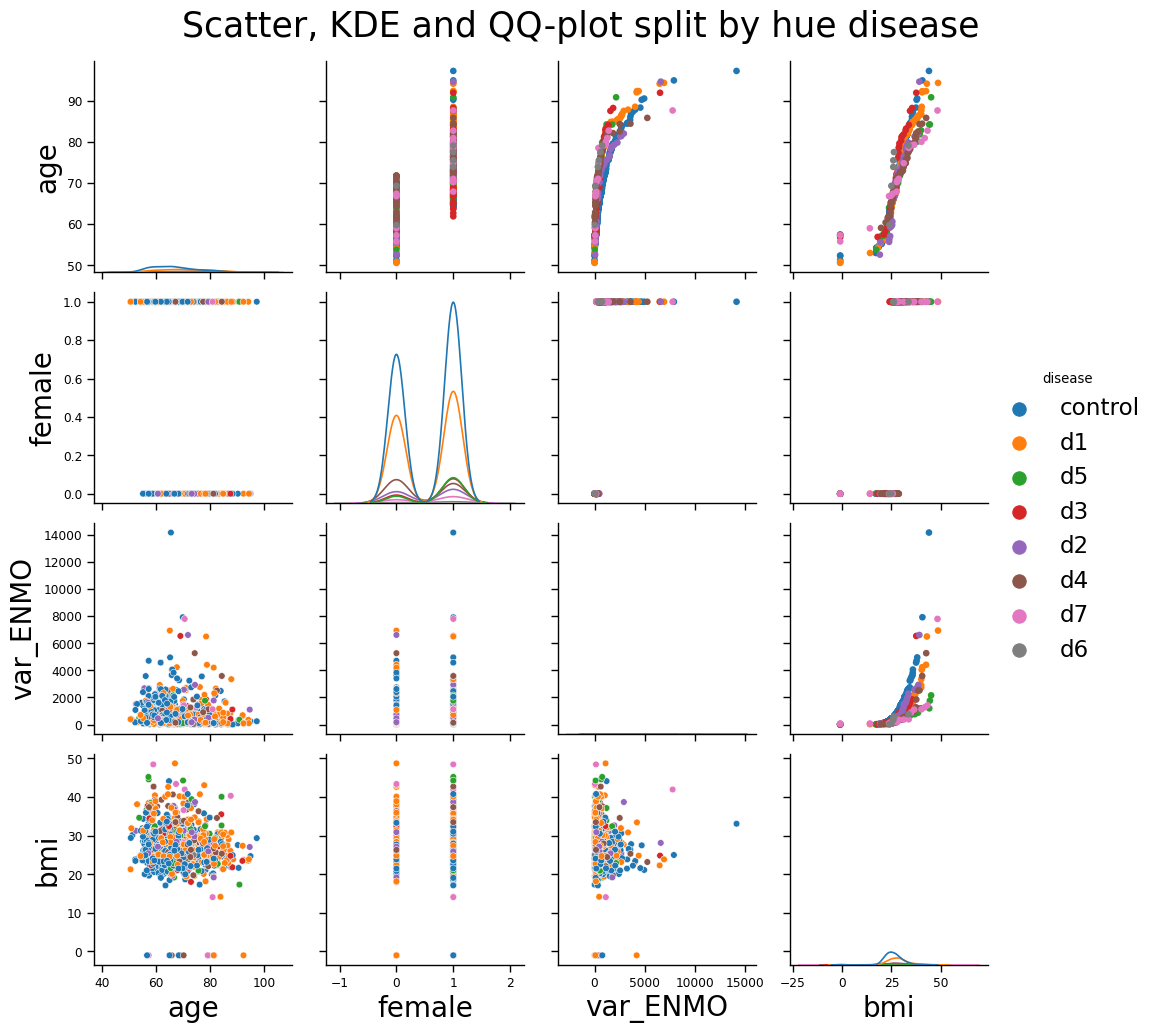

In [56]:
var= [
    'age', 'female', 
    'var_ENMO', #enmo
    'bmi', #behaviour risks
]
hue = 'disease'

sns.set_context("paper", rc={"axes.labelsize":20})

plt.figure(figsize=[10,10])
g = sns.PairGrid(data=df_stat, vars=var, hue=hue, dropna=True)
    #with sns.color_palette('viridis', n_colors=len(df_anno[hue].unique())):
g.map_upper(qqplot)
g.map_diag(sns.kdeplot, warn_singular=False)
g.map_lower(sns.scatterplot)

g.fig.suptitle(f'Scatter, KDE and QQ-plot split by hue {hue}', y=1.03, size=25)
g.add_legend(title = hue, title_fontsize='xx-large', fontsize='xx-large', markerscale=2)
#plt.savefig(os.path.join(plot_dir, f'scatter_kde_qq_{hue}.png'))
plt.show()

In [86]:
'''
from sklearn.decomposition import PCA
from sklearn import preprocessing


data = pd.crosstab(index=df['mergeid'], columns=df['disease'], values=df['ENMO_hour'], aggfunc={'ENMO_hour': np.var})
scaled_data = preprocessing.scale(data)

pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principle Component')
plt.title('Scree Plot')
plt.show()
'''

"\nfrom sklearn.decomposition import PCA\nfrom sklearn import preprocessing\n\n\ndata = pd.crosstab(index=df['mergeid'], columns=df['disease'], values=df['ENMO_hour'], aggfunc={'ENMO_hour': np.var})\nscaled_data = preprocessing.scale(data)\n\npca = PCA()\npca.fit(scaled_data)\npca_data = pca.transform(scaled_data)\n\nper_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)\nlabels = ['PC' + str(x) for x in range(1, len(per_var)+1)]\n\nplt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)\nplt.ylabel('Percentage of Explained Variance')\nplt.xlabel('Principle Component')\nplt.title('Scree Plot')\nplt.show()\n"

In [30]:
c = df_stat[df_stat['disease']=='control']['var_ENMO']
d1 = df_stat[df_stat['disease']=='d1']['var_ENMO']
d2 = df_stat[df_stat['disease']=='d2']['var_ENMO']
d3 = df_stat[df_stat['disease']=='d3']['var_ENMO']
d4 = df_stat[df_stat['disease']=='d4']['var_ENMO']
d5 = df_stat[df_stat['disease']=='d5']['var_ENMO']
d6 = df_stat[df_stat['disease']=='d6']['var_ENMO']
d7 = df_stat[df_stat['disease']=='d7']['var_ENMO']

In [31]:
stats.f_oneway(c, d1, d2, d3, d4, d5, d6, d7)

F_onewayResult(statistic=1.4755145486286452, pvalue=0.17238887431738265)

In [37]:
model = ols('median_ENMO ~ disease', data=df_stat).fit()

anova_result = sm.stats.anova_lm(model,typ=2)
print(anova_result)

                 sum_sq     df         F    PR(>F)
disease     4572.766393    7.0  1.473997  0.172943
Residual  375820.265605  848.0       NaN       NaN


In [38]:
model = ols('mean_ENMO ~ disease', data=df_stat).fit()

anova_result = sm.stats.anova_lm(model,typ=2)
print(anova_result)

                 sum_sq     df         F    PR(>F)
disease     4232.068281    7.0  1.528956  0.153818
Residual  335316.848012  848.0       NaN       NaN


Long to wide format

In [11]:
df.loc[:, 'measurementday'] = df.replace({1: 'day1', 2: 'day2', 3: 'day3', 4: 'day4', 5: 'day5', 6: 'day6', 7: 'day7'})
df_wide = df.pivot_table(index='mergeid', columns='measurementday', values='ENMO_hour', aggfunc={'ENMO_hour': np.mean})
df_wide.dropna(inplace=True)
df_wide = pd.merge(df_wide, df_stat, on='mergeid')
df_wide.head(5)

# alternative: https://www.statology.org/pandas-pivot-table-column-names/

,mergeid,day1,day2,day3,day4,day5,day6,day7,female,age,...,d2,d3,d4,d5,d6,d7,control,mean_ENMO,median_ENMO,var_ENMO
0,Bf-031257-01,7.842784,13.951765,14.691516,11.845631,15.103767,8.624473,13.088953,0,67.000000,...,0,0,0,0,0,0,1,12.164127,9.664236,119.962879
1,Bf-043946-02,14.734543,12.709763,11.554774,15.158368,8.666696,16.909890,16.726105,1,57.299999,...,0,0,0,0,0,0,0,13.780020,8.492361,209.996045
2,Bf-073169-01,25.244525,10.036458,12.613015,11.006794,21.812749,15.087454,16.835509,0,72.500000,...,0,0,0,0,0,0,0,16.090929,11.452292,537.459251
3,Bf-291361-02,42.403131,53.354855,53.780660,45.536817,44.093501,42.671858,40.565764,1,71.199997,...,0,0,0,0,0,0,1,46.058084,43.160000,1278.062974
4,Bf-294636-01,19.117378,15.019144,14.817222,15.841696,16.929803,16.612344,19.187679,1,55.900002,...,0,0,0,0,0,0,1,16.789324,15.660556,55.480780


In [56]:
maov = MANOVA.from_formula('day1 + day2 + day3 + day4 + day5 + day6 + day7 ~ d1 + d2 + d3 + d4 + d5 + d6 + d7', data=df_wide)
print(maov.mv_test())

                  Multivariate linear model
                                                             
-------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.5090 7.0000 706.0000 97.2797 0.0000
         Pillai's trace 0.4910 7.0000 706.0000 97.2797 0.0000
 Hotelling-Lawley trace 0.9645 7.0000 706.0000 97.2797 0.0000
    Roy's greatest root 0.9645 7.0000 706.0000 97.2797 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
           d1           Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9892 7.0000 706.0000  1.1053 0.3577
         Pillai's trace 0.0108 7.0000 706.0000  1.1053 0.3577
 Hotelling-Lawley trace 0.

In [ ]:
'''
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
# to test significance of the group differences 
X = df_stat[["d5", "control"]]
y = df_stat["ENMO_hour"]
y = y.astype(int)
post_hoc = lda().fit(X=X, y=y)

# plot 
X_new = pd.DataFrame(lda().fit(X=X, y=y).transform(X), columns=["lda1", "lda2"])
X_new["ENMO_hour"] = df_stat["ENMO_hour"]
sns.scatterplot(data=X_new, x="lda1", y="lda2", hue=df_stat.ENMO_hour.tolist())
plt.show()
'''

In [ ]:
'''
reg = ols('d1~ENMO_hour', data=df_stat).fit()
aov_d1 = sm.stats.anova_lm(reg, typ=2)
print(aov_d1)
'''